<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Metric" data-toc-modified-id="Metric-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Metric</a></span></li><li><span><a href="#Submission" data-toc-modified-id="Submission-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Submission</a></span></li><li><span><a href="#Recommendations" data-toc-modified-id="Recommendations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Recommendations</a></span></li></ul></div>

In [1]:
import json
from functools import partial
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split

### Load data

In [2]:
try:
    dataset = pd.read_parquet("hackathon_files_for_participants_ozon/train_pairs.parquet")
    etl = pd.read_parquet("hackathon_files_for_participants_ozon/train_data.parquet")
except:
    dataset = pd.read_parquet("F:/Хакатон/Датасеты/hackathon_files_for_participants_ozon/hackathon_files_for_participants_ozon/train_pairs.parquet")
    etl = pd.read_parquet("F:/Хакатон/Датасеты/hackathon_files_for_participants_ozon/hackathon_files_for_participants_ozon//train_data.parquet")

In [3]:
dataset.head(2)

,target,variantid1,variantid2
0,0.0,51197862,51198054
1,1.0,53062686,536165289


In [4]:
dataset["target"].value_counts()

0.0    171527
1.0    135013
Name: target, dtype: int64

In [5]:
etl.head(2)

,variantid,name,categories,color_parsed,pic_embeddings_resnet_v1,main_pic_embeddings_resnet_v1,name_bert_64,characteristic_attributes_mapping
0,51195767,"Удлинитель Партнер-Электро ПВС 2х0,75 ГОСТ,6A,...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[оранжевый],None,"[[0.04603629, 0.18839523, -0.09973055, -0.6636...","[-0.47045058, 0.67237014, 0.48984158, -0.54485...","{""Номинальный ток, А"":[""10""],""Цвет товара"":[""о..."
1,53565809,Магнитный кабель USB 2.0 A (m) - USB Type-C (m...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Кабели ...",[красный],"[[0.26863545, -0.3130674, 0.29023397, 0.073978...","[[1.1471839, -0.665361, 0.7745614, 0.26716197,...","[-0.6575592, 0.6522429, 0.5426037, -0.54347897...","{""Конструктивные особенности"":[""Магнитная конс..."


Get raw data for each variantid.

In [6]:
features = (
    dataset
    .merge(
        etl
        .add_suffix('1'),
        on="variantid1"
    )
    .merge(
        etl
        .add_suffix('2'),
        on="variantid2"
    )
)

In [7]:
features.head(2)

,target,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,name2,categories2,color_parsed2,pic_embeddings_resnet_v12,main_pic_embeddings_resnet_v12,name_bert_642,characteristic_attributes_mapping2
0,0.0,51197862,51198054,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",Удлинитель TDM Electric Люкс УЛ05В 1.5 м (SQ13...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.42941108, -0.5129398, -0.4753536, -0.0677...","[-0.455473, 0.58157134, 0.5870387, -0.5325003,...","{""Электробезопасность"":[""Заземление""],""Длина к..."
1,0.0,51197862,51199884,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",Удлинитель TDM Electric Люкс УЛ05В 3 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.43180764, -0.49580905, -0.5062628, -0.130...","[-0.5425725, 0.6415736, 0.51481575, -0.5687392...","{""Макс. нагрузка, Вт"":[""3500""],""Стандарт защит..."


Features functions.

In [8]:
from scipy.spatial.distance import canberra, chebyshev, sqeuclidean, braycurtis, hamming, jaccard

In [9]:
def get_pic_features(main_pic_embeddings_1,
                     main_pic_embeddings_2,
                     percentiles: List[int]):
    """Calculate distances percentiles for 
    pairwise pic distances. Percentiles are useful 
    when product has several pictures.
    """
    
    if main_pic_embeddings_1 is not None and main_pic_embeddings_2 is not None:
        main_pic_embeddings_1 = np.array([x for x in main_pic_embeddings_1])
        main_pic_embeddings_2 = np.array([x for x in main_pic_embeddings_2])
        
        dist_m = pairwise_distances(
            main_pic_embeddings_1, main_pic_embeddings_2
        )
    else:
        dist_m = np.array([[-1]])

    pair_features = []
    pair_features += np.percentile(dist_m, percentiles).tolist()

    return pair_features


In [10]:
get_pic_features_func = partial(
    get_pic_features,
    percentiles=[0, 25, 50]
)

In [11]:
features[["pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc"]] = (
    features[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1
    )
)

# btw try to add distances between main pic embs

In [12]:
def text_dense_distances(ozon_embedding, comp_embedding):
    """Calculate canberra and chebyshev distances between
    ozon_embedding and comp_embedding.
    """
    pair_features = []
    if ozon_embedding is None or comp_embedding is None:
        pair_features = [-1, -1]
    elif len(ozon_embedding) == 0 or len(comp_embedding) == 0:
        pair_features = [-1, -1]
    else:
        pair_features.append(
            canberra(ozon_embedding, comp_embedding)
        )
        cosine_value = chebyshev(ozon_embedding, comp_embedding)
        
        pair_features.append(cosine_value)

    return pair_features

In [13]:
features[["euclidean_name_bert_dist", "cosine_name_bert_dist"]] = (
    features[["name_bert_641", "name_bert_642"]].apply(
        lambda x: pd.Series(text_dense_distances(*x)), axis=1
    )
)

# try to use your favorite NLP model

In [14]:
features["cat3"] = features["categories1"].apply(lambda x: json.loads(x)["3"])
cat3_counts = features["cat3"].value_counts().to_dict()

Let's find good cat size threshold

In [15]:
cntr = 0
for cat3 in cat3_counts:
    if cat3_counts[cat3] < 1_000:
        cntr += cat3_counts[cat3]
        
cntr

10765

10k for "rest" cats probably is good

In [16]:
features["cat3_grouped"] = features["cat3"].apply(lambda x: x if cat3_counts[x] > 1000 else "rest")

Choose features

In [17]:
feats = ["pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc", 
         "euclidean_name_bert_dist", "cosine_name_bert_dist"]

Split dataset

In [18]:
X_train, X_test = train_test_split(
    features[feats + ["target", "variantid1", "variantid2", "cat3_grouped"]], 
    test_size=0.1, random_state=42, stratify=features[["target", "cat3_grouped"]]
)

X_train, X_val = train_test_split(
    X_train[feats + ["target",  "variantid1", "variantid2", "cat3_grouped"]], 
    test_size=0.1, random_state=42, stratify=X_train[["target", "cat3_grouped"]]
)

y_test = X_test[["target", "variantid1", "variantid2"]]
X_test = X_test.drop(["target"], axis=1)

y_train = X_train["target"]
y_val = X_val["target"]

X_train = X_train.drop(["target"], axis=1)
X_val = X_val.drop(["target"], axis=1)


train_pool = Pool(
    data=X_train[feats],
    label=y_train,
)
eval_pool = Pool(
    data=X_val[feats],
    label=y_val,
)

Train model

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.pipeline import make_pipeline
RANDOM = 12345

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [20]:
def fit_best_model (model):
    model = model.fit(X_train[feats], y_train)
    best_score = round(abs(model.best_score_), 2)
    print ('Параметры лучшей модели:', model.best_params_)
    print('accuracy лучшей модели:', best_score)
    return model, best_score

In [21]:
def initialization_pipeline (model, params):
    pipeline = make_pipeline(StandardScaler(), model)
    random_search = RandomizedSearchCV(model, param_distributions = params, scoring='accuracy', n_jobs=-1, cv=5,
                                      random_state=RANDOM)
    return random_search

In [22]:
def initialization (model, params):
    random_search = RandomizedSearchCV(model, param_distributions = params, scoring='accuracy', n_jobs=-1, cv=5,
                                      random_state=RANDOM)
    return random_search

In [23]:
#зададим параметры и инициируем модель
params_knn= {"n_neighbors": range(1,300),
           'weights': ['uniform', 'distance'],
            'metric' : ['minkowski','euclidean','manhattan']}

pipe_model_knn = initialization_pipeline (KNeighborsClassifier(), params_knn)

In [24]:
%%time
#выведем параметры лучшей модели:
model, best_score_knn=fit_best_model(pipe_model_knn)

Параметры лучшей модели: {'weights': 'distance', 'n_neighbors': 127, 'metric': 'manhattan'}
accuracy лучшей модели: 0.68
CPU times: total: 906 ms
Wall time: 1min 6s


### Metric

In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc


def pr_auc_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.75,
    cat_column: str = "cat3_grouped"
) -> float:

    df = target_df.merge(predictions_df, on=["variantid1", "variantid2"])

    y_true = df["target"]
    y_pred = df["scores"]
    categories = df[cat_column]

    weights = []
    pr_aucs = []

    unique_cats, counts = np.unique(categories, return_counts=True)

    # calculate metric for each big category
    for i, category in enumerate(unique_cats):
        # take just a certain category
        cat_idx = np.where(categories == category)[0]
        y_pred_cat = y_pred[cat_idx]
        y_true_cat = y_true[cat_idx]

        # if there is no matches in the category then PRAUC=0
        if sum(y_true_cat) == 0:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
            continue
        
        # get coordinates (x, y) for (recall, precision) of PR-curve
        y, x, _ = precision_recall_curve(y_true_cat, y_pred_cat)
        
        # reverse the lists so that x's are in ascending order (left to right)
        y = y[::-1]
        x = x[::-1]
        
        # get indices for x-coordinate (recall) where y-coordinate (precision) 
        # is higher than precision level (75% for our task)
        good_idx = np.where(y >= prec_level)[0]
        
        # if there are more than one such x's (at least one is always there, 
        # it's x=0 (recall=0)) we get a grid from x=0, to the rightest x 
        # with acceptable precision
        if len(good_idx) > 1:
            gt_prec_level_idx = np.arange(0, good_idx[-1] + 1)
        # if there is only one such x, then we have zeros in the top scores 
        # and the curve simply goes down sharply at x=0 and does not rise 
        # above the required precision: PRAUC=0
        else:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
            continue
        
        # calculate category weight anyway
        weights.append(counts[i] / len(categories))
        # calculate PRAUC for all points where the rightest x 
        # still has required precision 
        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
        except ValueError:
            pr_aucs.append(0)
            
    return np.average(pr_aucs, weights=weights)


In [26]:
X_test["scores"] = model.predict_proba(X_test[feats])[:, 1]

In [27]:
pr_auc_macro_metr = pr_auc_macro(
    target_df=y_test, 
    predictions_df=X_test,
    prec_level=0.75,
    cat_column="cat3_grouped"
)

pr_auc_macro_metr

0.2400933409469812

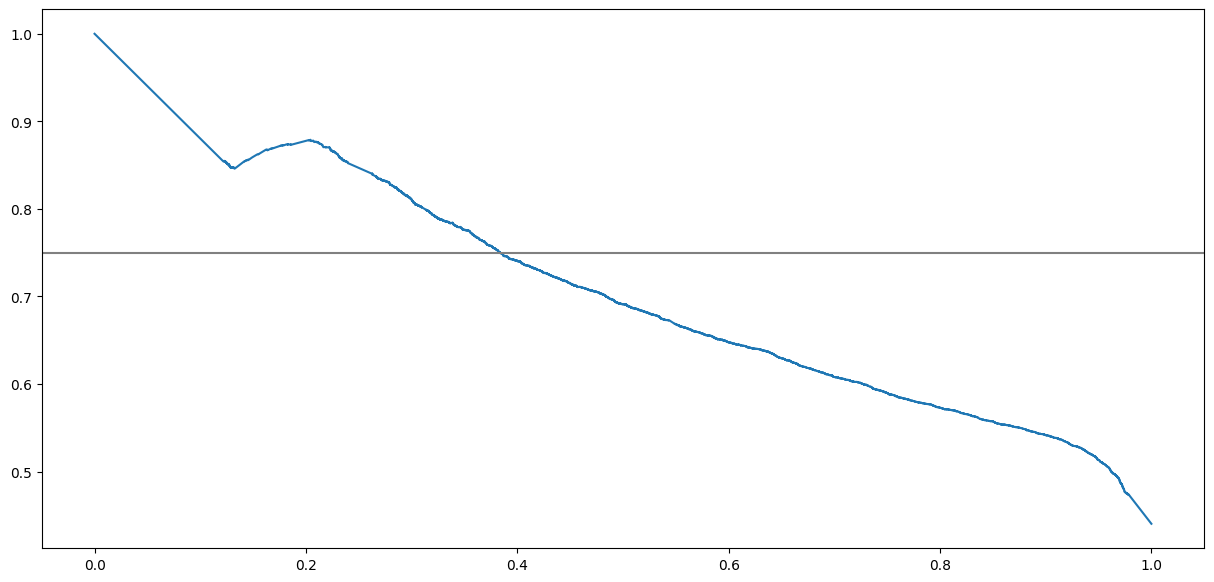

In [28]:
precision, recall, thrs = precision_recall_curve(y_test["target"], X_test["scores"])
pr_auc = auc(recall, precision)

fig, ax1 = plt.subplots(1, figsize=(15, 7))

ax1.plot(recall, precision)
ax1.axhline(y=0.75, color='grey', linestyle='-');

### Submission

In [29]:
try:
    test_pairs = pd.read_parquet("hackathon_files_for_participants_ozon/test_pairs_wo_target.parquet")
    test_etl = pd.read_parquet("hackathon_files_for_participants_ozon/test_data.parquet")

except:
    test_pairs = pd.read_parquet("F:/Хакатон/Датасеты/hackathon_files_for_participants_ozon/hackathon_files_for_participants_ozon/train_pairs.parquet")
    test_etl = pd.read_parquet("F:/Хакатон/Датасеты/hackathon_files_for_participants_ozon/hackathon_files_for_participants_ozon/train_data.parquet")

Generate the same features as for train

In [30]:
test_features = (
    test_pairs
    .merge(
        test_etl
        .add_suffix('1'),
        on="variantid1"
    )
    .merge(
        test_etl
        .add_suffix('2'),
        on="variantid2"
    )
)

In [31]:
test_features[["pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc"]] = (
    test_features[["main_pic_embeddings_resnet_v11", "main_pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1
    )
)

test_features[["euclidean_name_bert_dist", "cosine_name_bert_dist"]] = (
    test_features[["name_bert_641", "name_bert_642"]].apply(
        lambda x: pd.Series(text_dense_distances(*x)), axis=1
    )
)

In [32]:
test_features["cat3"] = test_features["categories1"].apply(lambda x: json.loads(x)["3"])

In [33]:
test_features.shape

(306540, 23)

In [34]:
test_cat3_counts = test_features["cat3"].value_counts().to_dict()

cntr = 0
for cat3 in test_cat3_counts:
    if test_cat3_counts[cat3] < 50:
        cntr += test_cat3_counts[cat3]
        
cntr

106

In [35]:
test_features["cat3_grouped"] = test_features["cat3"].apply(lambda x: x if test_cat3_counts[x] > 50 else "rest")
# btw you can rename to `rest` the same categories that were assigned to this group in train

In [36]:
submission_example = test_features.copy()

In [37]:
submission_example["target"] = model.predict_proba(test_features[feats])[:, 1]

In [38]:
submission_example = submission_example[["variantid1", "variantid2", "target"]]

In [39]:
submission_example.drop_duplicates().merge(
    test_features[["variantid1", "variantid2"]].drop_duplicates(["variantid1", "variantid2"]),
    on=["variantid1", "variantid2"]
).to_csv("submission_example.csv", index=False)

Upload your submission to leaderboard :)

### Recommendations 

- Work with names, in electronics names often contain a lot of useful information for matching.
- Don't forget about attributes: working with it will allow your model to better distinguish matches from non-matches.